In [1]:
import shutil
from dataclasses import dataclass

from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy, error_rate

import torch
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms

# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image as PILImage

In [2]:
PATH = Path.home()/'data'/'FERG_DB_256'
PREPARED = PATH/'flatten'

In [3]:
@dataclass
class LabelParser:
    method: str='emotion'
        
    def __post_init__(self):
        if self.method not in ('emotion', 'emotion_char'):
            self.method = 'emotion'
        
    def __call__(self, filename):
        char, emotion, *_ = filename.stem.split('_')
        if self.method == 'emotion':
            return emotion
        else:
            return f'{char}_{emotion}'

In [4]:
files = []
for name in PATH.ls():
    if name.endswith('.txt') or name.startswith('.'):
        continue
    char_dir = PATH/name
    for char_emotion in char_dir.ls():
        emotion_dir = char_dir/char_emotion
        files.extend([fname for fname in emotion_dir.glob('*')])

In [5]:
PREPARED.mkdir(parents=True, exist_ok=True)
for file in files:
    shutil.copy(file, PREPARED/file.name)

In [6]:
img_files = get_image_files(PREPARED)

In [7]:
# ok_files = []
# for file in img_files:
#     try:
#         Image.open(file).convert('RGB')
#         ok_files.append(file)
#     except OSError:
#         print(f'Cannot read file: {file.as_posix()}')

In [8]:
img_files.remove(Path('/home/ck/data/FERG_DB_256/flatten/bonnie_surprise_1389.png'))

In [9]:
parser = LabelParser()
data = ImageDataBunch.from_name_func(
    PREPARED, img_files, parser, ds_tfms=get_transforms(), bs=256, size=224)
data.normalize(imagenet_stats)

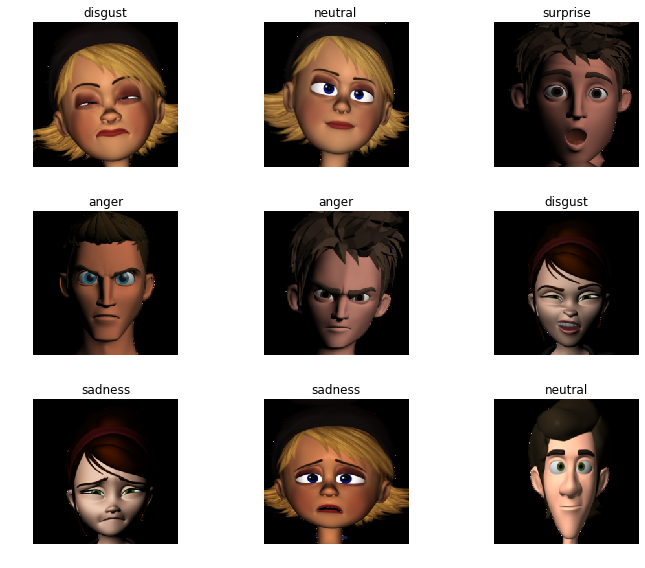

In [10]:
data.show_batch(3, figsize=(10, 8))

In [11]:
learn = ConvLearner(data, models.resnet34, metrics=[accuracy, error_rate])

In [12]:
learn.fit_one_cycle(5)

Total time: 07:57
epoch  train loss  valid loss  accuracy  error_rate
1      0.125606    0.004394    0.999554  0.000446    (01:37)
2      0.012028    0.000472    1.000000  0.000000    (01:35)
3      0.004276    0.000042    1.000000  0.000000    (01:34)
4      0.001465    0.000020    1.000000  0.000000    (01:35)
5      0.000929    0.000010    1.000000  0.000000    (01:35)



In [13]:
learn.save('model')

In [14]:
learn.load('model')

In [19]:
@dataclass
class ConvPredictor:
    
    learn: ConvLearner
    mean: Floats 
    std: Floats
        
    def __post_init__(self):
        device = self.learn.data.device
        self.mean, self.std = [torch.tensor(x).to(device) for x in (self.mean, self.std)]
        
    def predict(self, x):
        out = self.predict_logits(x)
        best_index = F.softmax(out).argmax()
        return self.learn.data.classes[best_index]
    
    def predict_logits(self, x):
        x = x.to(self.learn.data.device)
        x = normalize(x, self.mean, self.std)
        out = self.learn.model(x[None])
        return out
    
    def predict_from_file(self, filename):
        return self.predict(open_image(filename).data)

In [20]:
predictor = ConvPredictor(learn, *imagenet_stats)
predictor.predict_from_file(img_files[0])

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


'neutral'

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

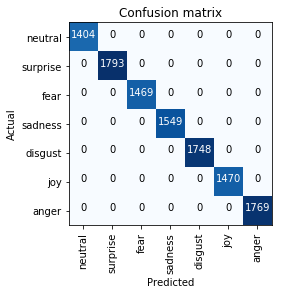

In [24]:
interp.plot_confusion_matrix()